$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \newcommand{\bnaive}{\widehat{\beta}}
    \newcommand{\bbayes}{\widetilde{\beta}}
    \newcommand{\bboot}{\beta^{*}}
    \newcommand{\bdouble}{\beta^{**}}
    \newcommand{\bbootnv}{\hat{\beta}^*}
    \newcommand{\bbootby}{\widetilde{\beta}^*}
    \newcommand{\bcorrect}{\beta^{\checkmark}}
    \newcommand{\bbayescorrect}{\widetilde{\beta}^{\checkmark}}
    \newcommand{\ybar}{\bar{Y}}
    \newcommand{\ypred}{\widetilde{y}}
    \newcommand{\ybarpred}{\widetilde{\bar{Y}}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\thresh}{\ybar{}_0}
    \newcommand{\muo}{\mu_{0}}
    \newcommand{\sigo}{\sigma_{0}}
    \newcommand{\hmt}{\bar{Y_t}}
    \newcommand{\hst}{s_t^2}
    \newcommand{\hmc}{\bar{Y_c}}
    \newcommand{\hsc}{s_c^2}
    \newcommand{\mt}{\mu_t}
    \newcommand{\sigt}{\sigma_t}
    \newcommand{\vt}{\sigma_t^2}
    \newcommand{\mc}{\mu_c}
    \newcommand{\vc}{\sigma_c^2}
    \newcommand{\sigc}{\sigma_c}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\below}{\unicode{x25E7}}
    \newcommand{\above}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jbelow}{\unicode{x21E5}}
    \newcommand{\jabove}{\unicode{x21E4}}
$$

Previously, we've shown an unfortunate behavior of our model: the posterior variance goes down even when we add data far away from the boundary. This is a feature of the 1GP model, whether kinky or vanilla. In this notebook, I'd like to propose a modification of the model to address this issue. The idea is to make the treatment effect decay to zero away from the boundary, so that only information near the discontinuity is used.

In [1]:
import PyPlot
plt=PyPlot
plt.svg(true)
using LaTeXStrings
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
;

# Simulate Data

In [13]:
module ⬠
    using Distributions
    using GaussianProcesses
    import PDMats
    
    import PyPlot
    plt=PyPlot
    plt.svg(true)
    using LaTeXStrings
    
    abstract Kmodifier
    type Separate <: Kmodifier
        thresh::Float64
    end
    type Kinky <: Kmodifier
        thresh::Float64
        n◫::Int
        kern::GaussianProcesses.Kernel
    end
    type Identity <: Kmodifier
    end
    type Decaying <: Kmodifier
        thresh::Float64
        n◫::Int
        kern::GaussianProcesses.Kernel
    end
    
    function modif!(km::Identity, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        return K
    end
    
    function modif!(km::Separate, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        ◧row = Xrow[:,1] .< km.thresh
        ◨row = !◧row
        ◧col = Xcol[:,1] .< km.thresh
        ◨col = !◧col
        
        K[◧row,◨col] = 0.0
        K[◨row,◧col] = 0.0
        return K
    end

    function modif!(km::Kinky, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        # legend:
        # ◧ points to the left of the boundary
        # ◨ points to the right of the boundary
        # ◫ points at the boundary

        ◧row = Xrow[:,1] .< km.thresh
        ◨row = !◧row
        n◧row = sum(◧row)

        ◧col = Xcol[:,1] .< km.thresh
        ◨col = !◧col
        n◧col = sum(◧col)

        # spatial positions
        X◧row = Xrow[◧row,:]
        X◨row = Xrow[◨row,:]
        X◧col = Xcol[◧col,:]
        X◨col = Xcol[◨col,:]
        X2◫ = linspace(minimum(Xrow[:,2])-1, maximum(Xrow[:,2])+1, n◫)
        X1◫ = ones(Float64, km.n◫) * km.thresh # all points on the boundary
        X◫ = [X1◫ X2◫]

        # K: separated kernel
        K◧◧ = K[◧row,◧col]
        K◨◨ = K[◨row,◨col]
        K◫◫ = GaussianProcesses.crossKern(X◫', km.kern)
        K◧◫ = GaussianProcesses.crossKern(X◧row', X◫', km.kern)
        K◨◫ = GaussianProcesses.crossKern(X◨row', X◫', km.kern)
        K◫◧ = GaussianProcesses.crossKern(X◫', X◧col', km.kern)
        K◫◨ = GaussianProcesses.crossKern(X◫', X◨col', km.kern)

        # L: variance removed by conditioning on continuity at boundary
        L = [K◧◫ ; -K◨◫] / (2*K◫◫) * [K◫◧ -K◫◨]

        # modify kernel
        K[◧row,◧col] = K◧◧ - L[1:n◧row,1:n◧col]
        K[◨row,◨col] = K◨◨ - L[n◧row+1:end,n◧col+1:end]
        K[◧row,◨col] = -L[1:n◧row,n◧col+1:end]
        K[◨row,◧col] = -L[n◧row+1:end,1:n◧col]
        return K
    end
    


    function simulate_GP{S<:Number,Ker<:Kernel}(kern::Ker, km::Kmodifier, X::AbstractMatrix{S})
        n = size(X,1)
        K = GaussianProcesses.crossKern(X', kern)
        Kmod = modif!(km, K, X, X)
        fXdistr = MvNormal(zeros(n), Kmod+ 1e-9*eye(n))
        fX = rand(fXdistr)
        return fX
    end
    function simulate_2GP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Separate(thresh)
        return simulate_GP(kern, km, X)
    end
    function simulate_1GP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Identity()
        return simulate_GP(kern, km, X)
    end
    function simulate_kinkyGP{S<:Number,Ker<:Kernel}(kern::Ker, thresh::Real, X::AbstractMatrix{S})
        km = Kinky(thresh, kern)
        return simulate_GP(kern, km, X)
    end
    
    ## Inference
    type CovarianceComponents{T<:Real}
        Σf::AbstractArray{T}
        Στ::AbstractArray{T}
        Σβ::AbstractArray{T}
        Σy::AbstractArray{T}
    end
    function g_VarY(cc::CovarianceComponents)
        cc.Σf + cc.Στ + cc.Σβ + cc.Σy
    end 

    function g_CC{T<:Number, S<:Number}(Xrow::Array{T}, Xcol::Array{T}, km::Kmodifier,
            thresh::T, στ2::T, σβ2::T, σy2::S, kern::SEIso)
        ◧row = Xrow[:,1] .< thresh
        ◨row = !◧row
        ◧col = Xcol[:,1] .< thresh
        ◨col = !◧col
        II = ◨row * ◨col'
        K = GaussianProcesses.crossKern(Xrow', Xcol', kern)
        Kmod = modif!(km, K, Xrow, Xcol)
        n = size(Xcol,1)
        In=eye(n)
        XXt = Xrow * Xcol'
        return CovarianceComponents(Kmod, στ2*II, σβ2*XXt, σy2*In)
    end

    function τ_posterior{T<:Real, S<:Number}(X::Array{Float64}, Y::Vector{Float64}, km::Kmodifier, 
            στ2::T, σβ2::T, σy2::S, kern::SEIso, thresh::Float64)
        cc = g_CC(X, X, km, thresh, στ2, σβ2, σy2, kern)
        VarY = PDMats.PDMat(g_VarY(cc))
        ◨ = (X[:,1] .> thresh)*1.0
        alpha = VarY \ Y
        Eτ_Y =(στ2 * ◨' * alpha)[1]
        Lck = PDMats.whiten(VarY, ◨'')
        Vτ_Y = (στ2 - στ2^2 .* Lck' * Lck)[1]
        τ_Y = Normal(Eτ_Y, √(Vτ_Y))
        return τ_Y
    end
    function modif!(km::Decaying, K::AbstractMatrix, Xrow::AbstractMatrix, Xcol::AbstractMatrix)
        # legend:
        # ◧ points to the left of the boundary
        # ◨ points to the right of the boundary
        # ◫ points at the boundary
        ◧row = Xrow[:,1] .< km.thresh
        ◨row = !◧row
        n◧row = sum(◧row)

        ◧col = Xcol[:,1] .< km.thresh
        ◨col = !◧col
        n◧col = sum(◧col)

        # spatial positions
        X◧row = Xrow[◧row,:]
        X◨row = Xrow[◨row,:]
        X◧col = Xcol[◧col,:]
        X◨col = Xcol[◨col,:]
        X2◫ = linspace(minimum(Xrow[:,2])-sqrt(km.kern.ℓ2) , maximum(Xrow[:,2])+1, km.n◫)
        X1◫ = ones(Float64, km.n◫) * km.thresh # all points on the boundary
        X◫ = [X1◫ X2◫]

        # K: separated kernel
        K◧◧ = K[◧row,◧col]
        K◨◨ = K[◨row,◨col]
        K◫◫ = GaussianProcesses.crossKern(X◫', km.kern)
        K◨◫ = GaussianProcesses.crossKern(X◨row', X◫', km.kern)
        K◫◨ = GaussianProcesses.crossKern(X◫', X◨col', km.kern)

        
        # D: take the sequential differences at the boundary
        Dδ◫◫ = copy(K◫◫[1:km.n◫-1,:])
        for i in 1:km.n◫-1
            Dδ◫◫[i,:] .-= K◫◫[i+1,:]
        end
        Dδ◫δ◫ = copy(Dδ◫◫[:,1:km.n◫-1])
        for i in 1:km.n◫-1
            Dδ◫δ◫[:,i] .-= Dδ◫◫[:,i+1]
        end
        D◨◫ = copy(K◨◫[:,1:km.n◫-1])
        for i in 1:km.n◫-1
            D◨◫[:,i] .-= K◨◫[:,i+1]
        end
        D◫◨ = copy(K◫◨[1:km.n◫-1,:])
        for i in 1:km.n◫-1
            D◫◨[i,:] .-= K◫◨[i+1,:]
        end        

        # Z: covariance once boundary points are forced to be equal
        Z◨◫ = K◨◫ - D◨◫ / Dδ◫δ◫ * Dδ◫◫
        Z◫◨t = K◫◨' - D◫◨' / Dδ◫δ◫ * Dδ◫◫
        
        Z◫◫ = (K◫◫[1,1] - Dδ◫◫[:,1]' / Dδ◫δ◫ * Dδ◫◫[:,1])[1]
        # scale back up to variance 1 at the boundary
        Z◨◫  ./= Z◫◫
        Z◫◨t ./= Z◫◫

        # covariance is induced by covariance with boundary
        Z◨◨ = Z◨◫[:,1] * Z◫◨t[:,1]'
        
        # modify kernel
        K[◨row,◨col] = Z◨◨
        K[◧row,:] = 0.0
        K[:,◧col] = 0.0
        
        return K, Z◨◫, Z◫◨t
    end    
    function τ_posterior_decay{T<:Real, S<:Number}(X::Array{Float64}, Y::Vector{Float64}, km::Kmodifier, 
            στ2::T, σβ2::T, σy2::S, kern::SEIso, thresh::Float64)
        cc = g_CC(X, X, km, thresh, στ2, σβ2, σy2, kern)
        ◨ = (X[:,1] .>= thresh)
        τkern = GaussianProcesses.SEIso(log(sqrt(kern.ℓ2)), 0.0)
        n◫ = 10
        τdecay = Decaying(0.0, n◫, τkern)
        cc.Στ[◨,◨], Z◨◫, Z◫◨t = modif!(τdecay, GaussianProcesses.crossKern(X[◨,:]', τkern), X[◨,:], X[◨,:])
        cc.Στ .*= στ2

        ΣYτ = zeros(size(X,1))
        ΣYτ[◨,:] = Z◨◫[:,1] * στ2
        VarY = PDMats.PDMat(g_VarY(cc))
        
        alpha = VarY \ Y
        Eτ_Y =(ΣYτ' * alpha)[1]
        Lck = PDMats.whiten(VarY, ΣYτ'')
        Vτ_Y = (στ2 - Lck' * Lck)[1]
        τ_Y = Normal(Eτ_Y, √(Vτ_Y))
        return τ_Y
    end
    function fτ_predict{T<:Real, S<:Number}(Xpred::Array{Float64}, Xobs::Array{Float64}, Y::Vector{Float64}, 
            km::Kmodifier, 
            στ2::T, σβ2::T, σy2::S, kern::SEIso, thresh::Float64)
        XXt = Symmetric(Xobs * Xobs')
        cc_obs = g_CC(Xobs, Xobs, km, thresh, στ2, σβ2, σy2, kern)

        VarY = PDMats.PDMat(g_VarY(cc_obs))
        alpha = VarY \ Y
        
        cc_pred = g_CC(Xpred, Xpred, km, thresh, στ2, σβ2, σy2, kern)
        Σfτ_pred = cc_pred.Σf + cc_pred.Στ
        
        cc_cross = g_CC(Xpred, Xobs, km, thresh, στ2, σβ2, σy2, kern)
        Σfτ_cross = cc_cross.Σf + cc_cross.Στ
        Lck = PDMats.whiten(VarY, Σfτ_cross')
        μpost = (Σfτ_cross * alpha)
        Σpost = Σfτ_pred - Lck'Lck
        return μpost, Σpost
    end
end

⬠

In [14]:
thresh = 0.0
# data-generating parameters
σf2_star = 2.0
Lstar  = 1.05
τstar = 2.75
σy2_star = 0.1
;

In [15]:
στ2 = 100.0 # diffuse normal prior on τ
kern = SE(log(Lstar), log(√σf2_star))

nx2=1
nx1 = 10000
X1 = linspace(-1000.0,1000.0,nx1)
X2 = [0.0]#linspace(0, 1, nx2)
X = zeros(Float64, (nx1*nx2,2))
for (i,x1x2) in enumerate(vec([(x1,x2) for x2 in X2, x1 in X1]))
    X[i,1] = x1x2[1]
    X[i,2] = x1x2[2]
end

@time sepfGP = ⬠.simulate_1GP(kern, thresh, X)
fTreated = copy(sepfGP)
fTreated[X[:,1].>thresh] += τstar
Y = fTreated + rand(Normal(0,√(σy2_star)), nx1*nx2)
;

  6.894586 seconds (95.18 k allocations: 3.730 GB, 4.59% gc time)


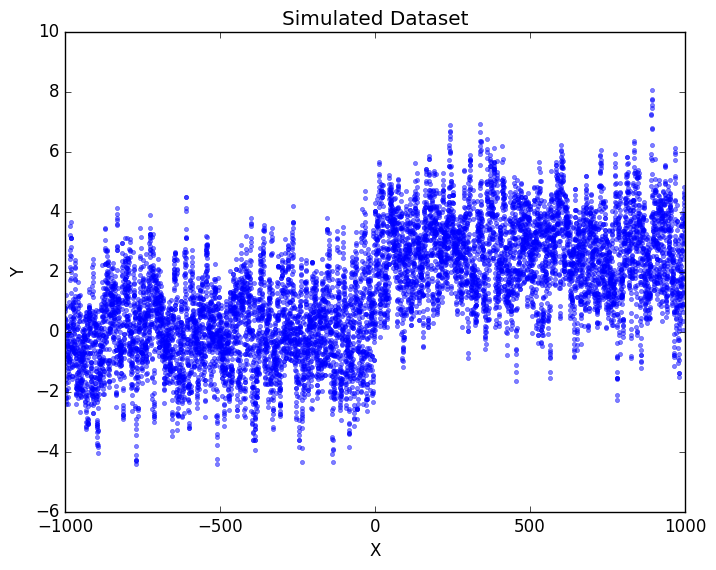

In [16]:
plt.svg(false)
plt.plot(X[:,1], Y, ".", alpha=0.5)
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

In [17]:
ithresh = searchsortedfirst(X[:,1], thresh)
npoints = round(Int, logspace(0,log10(4900),10))
τ_posteriors = Array(Normal, length(npoints))
for (i,n) in enumerate(npoints)
    Xsub = X[ithresh-n:ithresh+n,:]
    Ysub = Y[ithresh-n:ithresh+n]
    τpost = ⬠.τ_posterior(Xsub, Ysub, 
        ⬠.Identity(),
        στ2, 0.0, σy2_star, kern, thresh)
    τ_posteriors[i] = τpost
end

τ_postmeans = Float64[mean(τpost) for τpost in τ_posteriors]
τ_postvars =  Float64[var(τpost)  for τpost in τ_posteriors]
;

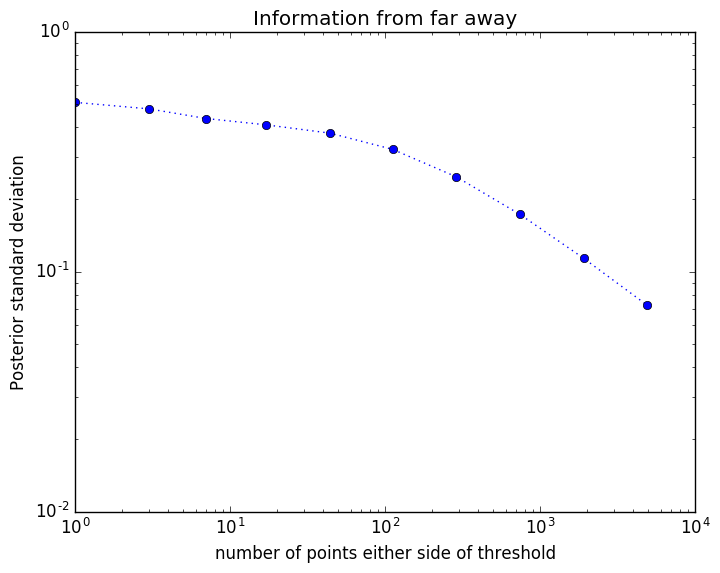

In [18]:
plt.svg(true)
plt.loglog(npoints, sqrt(τ_postvars), "o:")
plt.xlabel("number of points either side of threshold")
plt.ylabel("Posterior standard deviation")
plt.title("Information from far away")
;

# Decaying treatment effect

In [19]:
ithresh = searchsortedfirst(X[:,1], thresh)
τ_posteriors = Array(Normal, length(npoints))
for (i,n) in enumerate(npoints)
    Xsub = X[ithresh-n:ithresh+n,:]
    Ysub = Y[ithresh-n:ithresh+n]
    τpost = ⬠.τ_posterior_decay(Xsub, Ysub, 
        ⬠.Identity(),
        στ2, 0.0, σy2_star, kern, thresh)
    τ_posteriors[i] = τpost
end

τ_postmeans_decay = Float64[mean(τpost) for τpost in τ_posteriors]
τ_postvars_decay =  Float64[var(τpost)  for τpost in τ_posteriors]
;

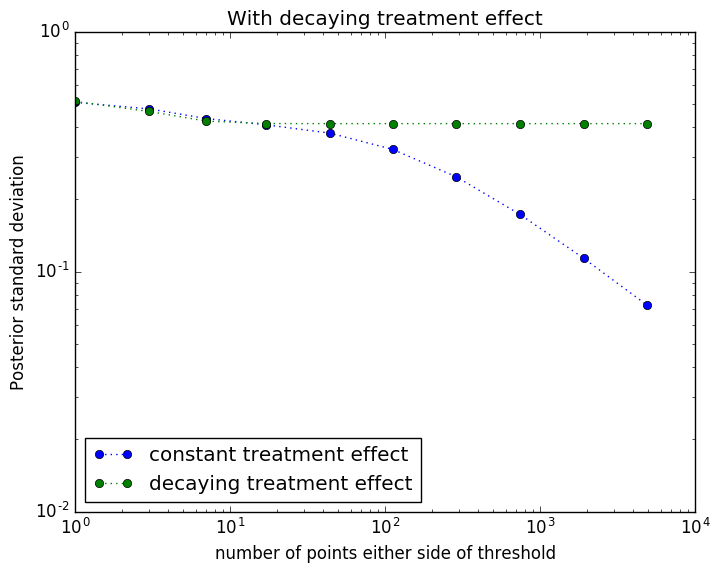

In [23]:
plt.loglog(npoints, sqrt(τ_postvars), "o:", label="constant treatment effect")
plt.loglog(npoints, sqrt(τ_postvars_decay), "o:", label="decaying treatment effect")
plt.xlabel("number of points either side of threshold")
plt.ylabel("Posterior standard deviation")
plt.title("With decaying treatment effect")
plt.legend(loc="lower left")
;

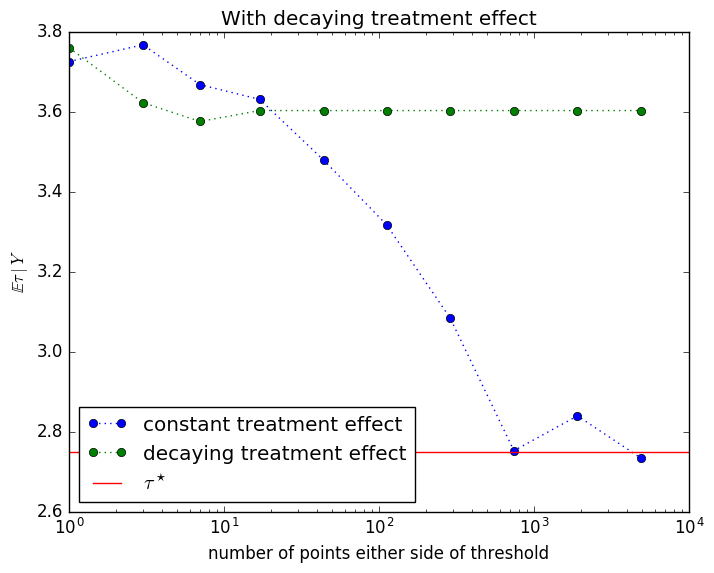

In [22]:
plt.semilogx(npoints, τ_postmeans, "o:", label="constant treatment effect")
plt.semilogx(npoints, τ_postmeans_decay, "o:", label="decaying treatment effect")
plt.axhline(τstar, color="red", label=L"\tau^\star")
plt.xlabel("number of points either side of threshold")
plt.ylabel(L"\mathbb{E}\tau \mid Y")
plt.title("With decaying treatment effect")
plt.legend(loc="lower left")
;

So the decaying kernel achieves its goal: we don't get any more information about $\tau$ as we add points more than a few lengthscales $L^\star$ away from the threshold. The posterior mean and variance stabilise, while previously under the constant treatment effect model, the posterior variance continues to go down, and then posterior mean continues to change (in this case towards the truth $\tau^\star$ since we *are* actually simulating data with a constant treatment effect.

** The Good **
* no more information at a distance, in the spirit of classic RDD
* able to handle non-linear boundaries between control and treatment
* still models the treatment effect as constant along the boundary (vs. 2GP model)

** The Bad **
* not motivated by a plausible data-generating process (i.e. this is an ad-hoc way to address the problem)
* hard to think about what it does exactly
* lower power when the constant treatment effect assumption is correct
* possibly introduces bias when the constant treatment effect assumption is correct?